In [64]:
import itertools

import pandas as pd
from plotnine import *
import scipy.special

%matplotlib inline

In [20]:
all_snps_df = pd.read_csv('../data/all_chromosome_snps.tsv.xz', compression='xz', sep='\t')

In [21]:
all_snps_df = all_snps_df.loc[:, ['#CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER']]
all_snps_df.head(2)

,#CHROM,POS,ID,REF,ALT,QUAL,FILTER
0,1,10505,rs548419688,A,T,100,PASS
1,1,10506,rs568405545,C,G,100,PASS


In [22]:
all_snps_df['num_variants'] = all_snps_df['ALT'].apply(lambda x: len(x.split(',')) + 1)

In [23]:
hapmap_df = pd.DataFrame()
for chromosome in range(1, 23):
    df = (
        pd.read_csv(f'../data/hapmap_snps/{chromosome}.txt.gz', sep='\t', compression='gzip')
        .assign(chromosome=chromosome)
    )
    hapmap_df = pd.concat([hapmap_df, df])

In [25]:
hapmap_df.head()

,rs,position,0,1,chromosome
0,rs11497407,558390,A,G,1
1,rs12565286,711153,C,G,1
2,rs11804171,713682,A,T,1
3,rs2977670,713754,C,G,1
4,rs2977656,719811,C,T,1


In [29]:
hapmap_df.shape

(2543887, 5)

In [30]:
hapmap_snps = hapmap_df.merge(all_snps_df, left_on=['chromosome', 'position'], 
                              right_on=['#CHROM', 'POS'], how='inner')

In [27]:
hapmap_snps.head()

,rs,position,0,1,chromosome,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,num_variants
0,rs3128126,952073,A,G,1,1,952073,rs191335531,G,C,100,PASS,2
1,rs4074137,1016570,A,C,1,1,1016570,rs534629103,G,C,100,PASS,2
2,rs12563338,1188481,A,T,1,1,1188481,rs376686951,G,A,100,PASS,2
3,rs6667923,1196206,A,C,1,1,1196206,rs572221129,C,T,100,PASS,2
4,rs2765033,1300787,C,T,1,1,1300787,rs576054064,G,A,100,PASS,2


In [35]:
hapmap_snps.shape

(75605, 13)

In [34]:
plot_values = (
    pd.value_counts(hapmap_snps['num_variants'])
    .reset_index()
    .rename(columns={'index': 'Number of variants', 'num_variants': 'Number of SNPs'})
)

plot_values

,Number of variants,Number of SNPs
0,2,75285
1,3,313
2,4,6
3,5,1


/home/zietzm/miniconda3/envs/epi-analysis/lib/python3.7/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units))
/home/zietzm/miniconda3/envs/epi-analysis/lib/python3.7/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: ../img/SNP_variants.png
  warn('Filename: {}'.format(filename))


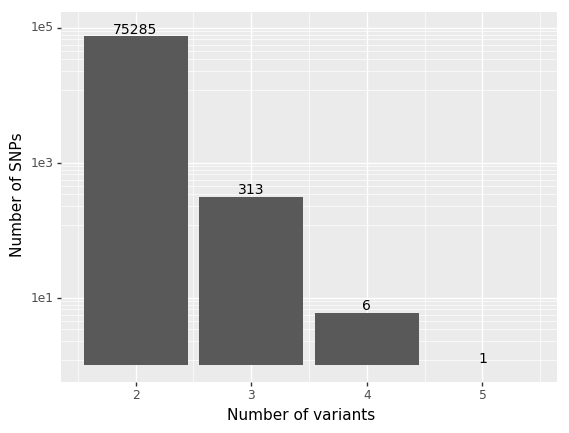

<ggplot: (-9223363304430646149)>

In [54]:
g = (
    ggplot(plot_values, aes(x='Number of variants', y='Number of SNPs', label='Number of SNPs'))
    + geom_bar(stat='identity')
    + scale_y_log10()
    + geom_text(size = 10, position=position_nudge(y=0.1))
)
ggsave(g, '../img/SNP_variants.png', dpi=500)
g

## Degrees of freedom

In [87]:
plot_values = (
    plot_values.assign(
        frequency = plot_values['Number of SNPs'] / plot_values['Number of SNPs'].sum(),
        extrap = lambda df: (df['frequency'] * 2543887).astype(int),
    )
)

plot_values

,Number of variants,Number of SNPs,frequency,extrap
0,2,75285,0.995767,2533119
1,3,313,0.004140,10531
2,4,6,0.000079,201
3,5,1,0.000013,33


In [88]:
N = plot_values['extrap'].sum()

num_coef = [scipy.special.binom(N, i) * 2**i for i in range(1, 6)]

num_coef

[5087768.0,
 12942686523144.0,
 2.1949778185245737e+19,
 2.7918811839830554e+25,
 2.840884282524326e+31]

In [92]:
coef_df = pd.DataFrame({'interaction': range(1, 6), 'num_coef': num_coef})
coef_df

,interaction,num_coef
0,1,5.087768e+06
1,2,1.294269e+13
2,3,2.194978e+19
3,4,2.791881e+25
4,5,2.840884e+31


/home/zietzm/miniconda3/envs/epi-analysis/lib/python3.7/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units))
/home/zietzm/miniconda3/envs/epi-analysis/lib/python3.7/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: ../img/degrees_of_freedom.png
  warn('Filename: {}'.format(filename))


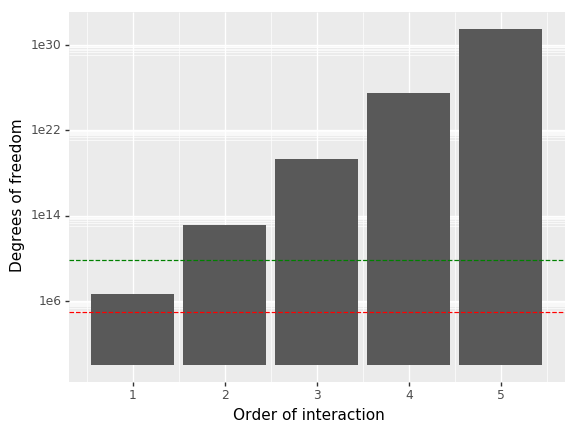

<ggplot: (8732424069198)>

In [112]:
g = (
    ggplot(coef_df, aes(x='interaction', y='num_coef', label='num_coef'))
    + geom_bar(stat='identity')
    + scale_y_log10()
    + ylab('Degrees of freedom')
    + xlab('Order of interaction')
#     + geom_text(size = 10, position=position_nudge(y=1))
    + geom_hline(yintercept=100000, color='red', linetype='dashed')
    + geom_hline(yintercept=7_700_000_000, color='green', linetype='dashed')
)
ggsave(g, '../img/degrees_of_freedom.png', dpi=500)
g

In [110]:
1.294269e+13

12942690000000.0

In [113]:
7.7e9

7700000000.0

In [ ]:
12_942_690_000_000.0